In [2]:
import projectq
from projectq.ops import All, Measure, QubitOperator, TimeEvolution, X, HGate,Rz,Ry,Rz,CNOT
from scipy.optimize import minimize
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
raw_data = np.loadtxt("hamiltonians.txt")
coeff_hams= raw_data[:,1:]
bond_distances=raw_data[:,0]
n_samples,n_features=coeff_hams.shape[0],coeff_hams.shape[1]

def ham(config_Hs,i):
    #bond_distances.append(config_H[i,0])
    config_H=config_Hs[i,:]
    hamiltonian = config_H[0] * QubitOperator(())  # == identity
    hamiltonian += config_H[1] * QubitOperator("Z0")
    hamiltonian += config_H[2] * QubitOperator("Z1")
    hamiltonian += config_H[3] * QubitOperator("Z0 Z1")
    hamiltonian += config_H[4] * QubitOperator("X0 X1")
    hamiltonian += config_H[5] * QubitOperator("Y0 Y1")
    #return energies/thetas.shape[0] 
    return hamiltonian

In [4]:
hams=[ham(coeff_hams,i) for i in range(n_samples)]

In [5]:
def loss_H(theta,ham):
    # Create a ProjectQ compiler with a simulator as a backend

    eng = projectq.MainEngine()
    # Allocate 2 qubits in state |00>
    wf= eng.allocate_qureg(2)
    # Initialize the Hartree Fock state |01>
    X | wf[0]
    ansatz_op1 = QubitOperator('X0 Y1')
    ansatz_op2 = 2*QubitOperator('X0')+1.5*QubitOperator('X1')
    # Apply the unitary e^{-i * ansatz_op * t}
    TimeEvolution(-theta[0]/2, ansatz_op1) | wf 
    TimeEvolution(theta[1], ansatz_op2) | wf 
    eng.flush()
    energy = eng.backend.get_expectation_value(ham, wf)
    All(Measure) | wf
    return energy

# fix the Hamiltonian
def landscape_H(thetas,ham):
    es=[]
    for i in range(thetas.shape[0]):
        es.append(loss_H(thetas[i,:],ham))
    return np.array(es).tolist()

# all Hamiltonians
def landscape_Hs(thetas,hams):
    es=[]
    for i in range(len(hams)):
        es.append(landscape_H(thetas,hams[i]))
    return np.array(es)

In [44]:
xs = np.linspace(-np.pi,np.pi,40)
ys = np.linspace(-np.pi,np.pi,40)
#xs = np.linspace(np.pi/2-0.5,np.pi/2+0.5,10)
#ys = np.linspace(np.pi/2-0.5,np.pi/2+0.5,10)
thetas=np.array([[x,y] for x in xs for y in ys])

In [51]:
len(hams)

54

In [62]:
# landscapes=landscape_Hs(thetas,hams[5:6])
landscapes=landscape_Hs(thetas,hams[2:3])
landscapes=landscapes.reshape(1,40,40)

In [48]:
t_history_nosnake[:,2,:]

array([[-0.67817816, -0.64708874],
       [-0.72908232, -0.63857901],
       [-1.29584703, -0.82805296],
       [-2.81301756, -0.90889021],
       [-3.1215198 , -0.90707252],
       [-3.15117176, -0.90700933],
       [-3.15396567, -0.90698269],
       [-3.15422901, -0.90698123],
       [-3.15425383, -0.90698104],
       [-3.15425617, -0.90698102],
       [-3.15425639, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102]])

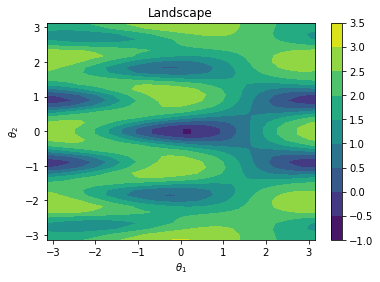

In [65]:
fig=plt.figure()
ax = fig.gca()
x = np.linspace(-np.pi,np.pi,40)
y = np.linspace(-np.pi,np.pi,40)
#x= np.linspace(np.pi/2-1,np.pi/2+1,10)
#y = np.linspace(np.pi/2-1,np.pi/2+1,10)
x, y = np.meshgrid(x, y)#生成网格点
z=landscapes[0,:,:]
# Plot the 3D surface
cset=plt.contourf(y,x,z)
plt.colorbar(cset)


#ax.plot_surface(x, y, z, rcount =100, ccount = 100, cmap ="jet", alpha = 0.8)
#rcount，ccount为绘制曲面时网格片的行数和列数
#help(ax.plot_surface)
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)
#ax.set_zlim(-2, 2)
ax.set_xlabel('$\\theta_1$')
ax.set_ylabel('$\\theta_2$')
#ax.set_zlabel('Z')
ax.set_title("Landscape")
plt.savefig("landscape.jpg",dpi=300)

plt.show()

In [92]:
with open('theta_history.txt', 'rb') as fp:
    theta_history = pickle.load(fp)
with open('theta_history_nosnake.txt', 'rb') as fp:
    theta_history_nosnake = pickle.load(fp)   
t_history = np.array(theta_history)
t_history_nosnake = np.array(theta_history_nosnake)

t_history_nosnake[t_history_nosnake<-np.pi] = -np.pi


In [102]:
t_history[:,2,0]
t_history_nosnake[:,2,0]

array([-0.67817816, -0.72908232, -1.29584703, -2.81301756, -3.1215198 ,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265])

In [118]:
t_history[0,2,1] - t_history_nosnake[0,2,1]

0.0

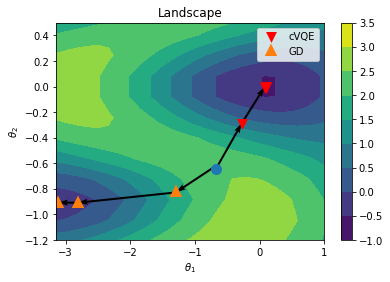

In [164]:
fig=plt.figure()
ax = fig.gca()
x = np.linspace(-np.pi,np.pi,40)
y = np.linspace(-np.pi,np.pi,40)
#x= np.linspace(np.pi/2-1,np.pi/2+1,10)
#y = np.linspace(np.pi/2-1,np.pi/2+1,10)
x, y = np.meshgrid(x, y)#生成网格点
z=landscapes[0,:,:]
# Plot the 3D surface
cset=plt.contourf(y,x,z)
plt.colorbar(cset)



x1 = t_history[:,2,0]
y1 = t_history[:,2,1]
u1 = np.array([x1[i+1]-x1[i] for i in range(len(x1)-1)])
v1 = np.array([y1[i+1]-y1[i] for i in range(len(y1)-1)])
plt.quiver(x1[:5],y1[:5],u1[:5],v1[:5],angles='xy', scale_units='xy', scale=1) 

x2 = t_history_nosnake[:,2,0]
y2 = t_history_nosnake[:,2,1]
u2 = np.array([x2[i+1]-x2[i] for i in range(len(x2)-1)])
v2 = np.array([y2[i+1]-y2[i] for i in range(len(y2)-1)])
plt.quiver(x2[:5],y2[:5],u2[:5],v2[:5],angles='xy', scale_units='xy', scale=1) 


plt.plot(t_history[0,2,0], t_history[0,2,1], 
         'C0o',mew ='5',alpha=1)

plt.plot(t_history[1:5,2,0], t_history[1:5,2,1], 
         'rv',mew ='3',alpha=1,label='cVQE')

plt.plot(t_history_nosnake[2:5,2,0], t_history_nosnake[2:5,2,1], 
         'C1^',mew ='4',alpha=1,label="GD")


#ax.plot_surface(x, y, z, rcount =100, ccount = 100, cmap ="jet", alpha = 0.8)
#rcount，ccount为绘制曲面时网格片的行数和列数
#help(ax.plot_surface)
ax.set_xlim(-np.pi, 1)
ax.set_ylim(-1.2, 0.5)
#ax.set_zlim(-2, 2)
ax.set_xlabel('$\\theta_1$')
ax.set_ylabel('$\\theta_2$')
#ax.set_zlabel('Z')
ax.set_title("Landscape")
plt.savefig("landscape_flow.jpg",dpi=300)
plt.legend()
plt.show()

In [ ]:
z.min()

In [ ]:
z.min(axis=0)

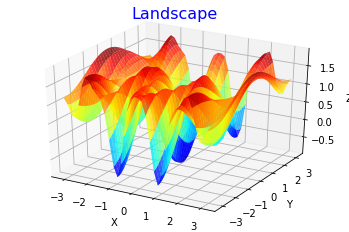

In [19]:
fig=plt.figure()
ax = fig.gca(projection="3d")
x = np.linspace(-np.pi,np.pi,40)
y = np.linspace(-np.pi,np.pi,40)
#x= np.linspace(np.pi/2-1,np.pi/2+1,10)
#y = np.linspace(np.pi/2-1,np.pi/2+1,10)
x, y = np.meshgrid(x, y)#生成网格点
z=landscapes[0,:,:]
# Plot the 3D surface
#cset=plt.contourf(x,y,z)
#plt.colorbar(cset)

ax.plot_surface(x, y, z, rcount =100, ccount = 100, cmap ="jet", alpha = 0.8)
#rcount，ccount为绘制曲面时网格片的行数和列数
#help(ax.plot_surface)
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)
#ax.set_zlim(-2, 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Landscape",fontsize =16, color ="b")
plt.show()

In [ ]:
z.min(axis=1)

In [ ]:
z.min()

In [ ]:
np.where(z==z.min())